# MADDPG

### Imports

In [1]:
import numpy as np
from pettingzoo.atari import boxing_v2
import numpy as np
import random 
import torch
import torch.nn as nn
import torch.optim as optim
from supersuit import pad_observations_v0, pad_action_space_v0, resize_v1, normalize_obs_v0, frame_skip_v0, dtype_v0
from pettingzoo.utils import aec_to_parallel
import matplotlib.pyplot as plt
from collections import defaultdict

## Critic and Actor Class

In [ ]:
class Critic(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(Critic, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, obs, actions):
        # Ensure observations are flattened
        obs = obs.flatten(start_dim=1) if len(obs.shape) > 2 else obs
        actions = actions.flatten(start_dim=1) if len(actions.shape) > 2 else actions

        # Debugging shapes
        #print(f"obs shape: {obs.shape}, actions shape: {actions.shape}")

        x = torch.cat([obs, actions], dim=-1)
        return self.fc(x)
    
class Actor(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(Actor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Tanh(),
        )

    def forward(self, obs):
        return self.fc(obs)

## MADDPG Agent

In [3]:
class MADDPGAgent:
    def __init__(self, obs_dim, action_dim, lr_actor=1e-3, lr_critic=1e-3):
        self.actor = Actor(obs_dim, action_dim)
        self.critic = Critic(obs_dim * 2, action_dim * 2)
        self.actor_target = Actor(obs_dim, action_dim)
        self.critic_target = Critic(obs_dim * 2, action_dim * 2)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        self.update_target(1.0)

    def update_target(self, tau):
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

In [4]:
class MADDPGAgent:
    def __init__(self, obs_dim, action_dim, lr_actor=1e-3, lr_critic=1e-3):
        self.actor = Actor(obs_dim, action_dim)
        self.critic = Critic(obs_dim * 2, action_dim * 2)
        self.actor_target = Actor(obs_dim, action_dim)
        self.critic_target = Critic(obs_dim * 2, action_dim * 2)

        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        self.update_target(1.0)

    def update_target(self, tau):
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def load_actor(self, path):
        """
        Load the actor model from a saved checkpoint.
        """
        self.actor.load_state_dict(torch.load(path))
        self.actor.eval()  # Set the actor to evaluation mode

    def load_critic(self, path):
        """
        Load the critic model from a saved checkpoint.
        """
        self.critic.load_state_dict(torch.load(path))
        self.critic.eval()  # Set the critic to evaluation mode


## MADDPG Wrapper

In [5]:
class MADDPG:
    def __init__(self, obs_dim, action_dim, n_agents, gamma=0.95, tau=0.01):
        self.agents = [MADDPGAgent(obs_dim, action_dim) for _ in range(n_agents)]
        self.gamma = gamma
        self.tau = tau

    def update(self, replay_buffer, batch_size):
        policy_loss = 0
        value_loss = 0

        for agent_idx, agent in enumerate(self.agents):
            obs, actions, rewards, next_obs, dones = replay_buffer.sample(batch_size)
            obs = torch.tensor(obs, dtype=torch.float32).flatten(start_dim=2)  # Flatten observations
            actions = torch.tensor(actions, dtype=torch.float32).flatten(start_dim=2)  # Flatten actions

            rewards = torch.tensor(rewards[:, agent_idx], dtype=torch.float32).unsqueeze(-1)
            next_obs = torch.tensor(next_obs, dtype=torch.float32).flatten(start_dim=2)
            dones = torch.tensor(dones[:, agent_idx], dtype=torch.float32).unsqueeze(-1)

            # Critic update
            with torch.no_grad():
                next_actions = torch.cat([
                    ag.actor_target(next_obs[:, i]) for i, ag in enumerate(self.agents)
                ], dim=-1)
                target_q = rewards + self.gamma * (1 - dones) * agent.critic_target(next_obs, next_actions)

            q_value = agent.critic(obs, actions)
            critic_loss = nn.MSELoss()(q_value, target_q)
            agent.critic_optimizer.zero_grad()
            critic_loss.backward()
            agent.critic_optimizer.step()
            value_loss += critic_loss.item()

            # Actor update
            predicted_actions = torch.cat([
                agent.actor(obs[:, i]) if i == agent_idx else actions[:, i] for i, _ in enumerate(self.agents)
            ], dim=-1)
            actor_loss = -agent.critic(obs, predicted_actions).mean()
            agent.actor_optimizer.zero_grad()
            actor_loss.backward()
            agent.actor_optimizer.step()
            policy_loss += actor_loss.item()

            # Update targets
            agent.update_target(self.tau)

        return policy_loss / len(self.agents), value_loss / len(self.agents)

## Buffer

In [6]:
class ReplayBuffer:
    def __init__(self, max_size, obs_dim, action_dim, n_agents):
        self.max_size = max_size
        self.ptr = 0
        self.size = 0
        self.obs = np.zeros((max_size, n_agents, obs_dim))
        self.actions = np.zeros((max_size, n_agents, action_dim))
        self.rewards = np.zeros((max_size, n_agents))
        self.next_obs = np.zeros((max_size, n_agents, obs_dim))
        self.dones = np.zeros((max_size, n_agents))

    def store(self, obs, actions, rewards, next_obs, dones):
        self.obs[self.ptr] = obs
        self.actions[self.ptr] = actions
        self.rewards[self.ptr] = rewards
        self.next_obs[self.ptr] = next_obs
        self.dones[self.ptr] = dones
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        idx = np.random.choice(self.size, batch_size, replace=False)
        return (
            self.obs[idx],
            self.actions[idx],
            self.rewards[idx],
            self.next_obs[idx],
            self.dones[idx],
        )

## Environment setup

In [7]:
# Environment setup
env = boxing_v2.env(render_mode="rgb_array")
env.reset(seed=42)
env = pad_observations_v0(env)
env = pad_action_space_v0(env)
env = resize_v1(env, 84, 84)
env = dtype_v0(env, dtype="float32")
env = normalize_obs_v0(env, env_min=0, env_max=1)
parallel_env = aec_to_parallel(env)

obs_dim = 84 * 84
action_dim = parallel_env.action_space("first_0").n
n_agents = 2
maddpg = MADDPG(obs_dim, action_dim, n_agents)
replay_buffer = ReplayBuffer(100000, obs_dim, action_dim, n_agents)


Testing MADDPG Agent 0 against Random Agent...
Episode 1/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 2/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 3/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 4/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 5/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 6/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 7/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 8/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 9/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 10/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0

Testing MADDPG Agent 1 against Random Agent...
Episode 1/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 2/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 3/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 4/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 5/10 (Steps: 10):
  first_0: 0.0
  second_0: 0.0
Episode 6/10 (Steps: 10):
  first_0: 0.0
  secon

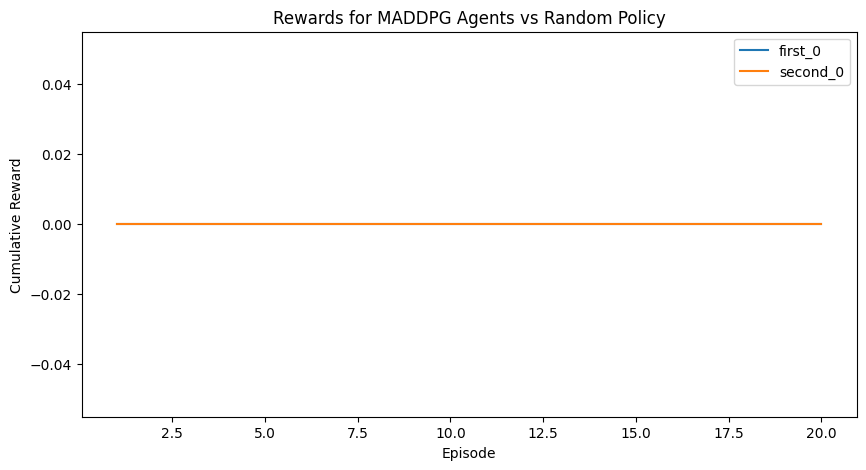

In [9]:
# Test trained MADDPG agents against a random policy agent
def test_agent_against_random(maddpg, parallel_env, num_test_episodes=10, max_steps=10):
    agent_rewards = defaultdict(list)

    for agent_idx in range(len(maddpg.agents)):  # Test each MADDPG agent
        print(f"\nTesting MADDPG Agent {agent_idx} against Random Agent...")
        
        for episode in range(num_test_episodes):
            obs = parallel_env.reset()
            if isinstance(obs, tuple):
                obs = obs[0]  # Handle tuple observations

            done = {agent: False for agent in parallel_env.agents}
            episode_reward = defaultdict(float)  # Track cumulative rewards
            step_count = 0  # Step counter for the episode

            while not all(done.values()) and step_count < max_steps:
                actions = {}
                for agent in parallel_env.agents:
                    if int(agent.split('_')[1]) == agent_idx:  # MADDPG agent
                        obs_preprocessed = torch.tensor(obs[agent], dtype=torch.float32)
                        if len(obs_preprocessed.shape) > 2:  # Ensure grayscale
                            obs_preprocessed = obs_preprocessed.mean(axis=-1)
                        obs_preprocessed = obs_preprocessed.flatten().unsqueeze(0)

                        # MADDPG agent's action
                        action = maddpg.agents[agent_idx].actor(obs_preprocessed).detach().numpy()
                        actions[agent] = np.argmax(action)  # Convert to discrete action
                    else:  # Random agent
                        actions[agent] = parallel_env.action_space(agent).sample()

                # Step the environment
                step_output = parallel_env.step(actions)
                if isinstance(step_output, tuple):
                    next_obs, rewards, dones, truncations, infos = step_output
                    dones = {agent: dones[agent] or truncations[agent] for agent in dones}
                else:
                    next_obs, rewards, dones, infos = step_output

                # Accumulate rewards
                for agent, reward in rewards.items():
                    episode_reward[agent] += reward

                obs = next_obs
                step_count += 1  # Increment step count

            # Store cumulative rewards for the episode
            for agent in parallel_env.agents:
                agent_rewards[agent].append(episode_reward[agent])

            print(f"Episode {episode + 1}/{num_test_episodes} (Steps: {step_count}):")
            for agent, reward in episode_reward.items():
                print(f"  {agent}: {reward}")

    return agent_rewards


# Test the trained agents
test_rewards = test_agent_against_random(maddpg, parallel_env, num_test_episodes=10)

# Plot the rewards
plt.figure(figsize=(10, 5))
for agent, rewards in test_rewards.items():
    plt.plot(range(1, len(rewards) + 1), rewards, label=agent)

plt.title("Rewards for MADDPG Agents vs Random Policy")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()


In [10]:
import os
checkpoint_path = "maddpg_checkpoints/checkpoint_episode_25"
def load_checkpoint(maddpg, checkpoint_path, episode_number):
    checkpoint_dir = os.path.join(checkpoint_path, f"checkpoint_episode_{episode_number}")
    for idx, agent in enumerate(maddpg.agents):
        actor_path = os.path.join(checkpoint_dir, f"agent_{idx}_actor.pth")
        critic_path = os.path.join(checkpoint_dir, f"agent_{idx}_critic.pth")
        actor_target_path = os.path.join(checkpoint_dir, f"agent_{idx}_actor_target.pth")
        critic_target_path = os.path.join(checkpoint_dir, f"agent_{idx}_critic_target.pth")

        # Load models
        agent.actor.load_state_dict(torch.load(actor_path))
        agent.critic.load_state_dict(torch.load(critic_path))
        agent.actor_target.load_state_dict(torch.load(actor_target_path))
        agent.critic_target.load_state_dict(torch.load(critic_target_path))
    print(f"Loaded checkpoint from episode {episode_number}.")


Loaded checkpoint from episode 25.

Testing MADDPG Agent 0 against Random Agent...
Episode 1/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 2/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 3/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 4/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 5/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 6/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 7/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 8/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 9/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 10/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0

Testing MADDPG Agent 1 against Random Agent...
Episode 1/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 2/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 3/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 4/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 5/10 (Steps: 50):
  first_0: 0.0
  second_0: 0.0
Episode 6/10 

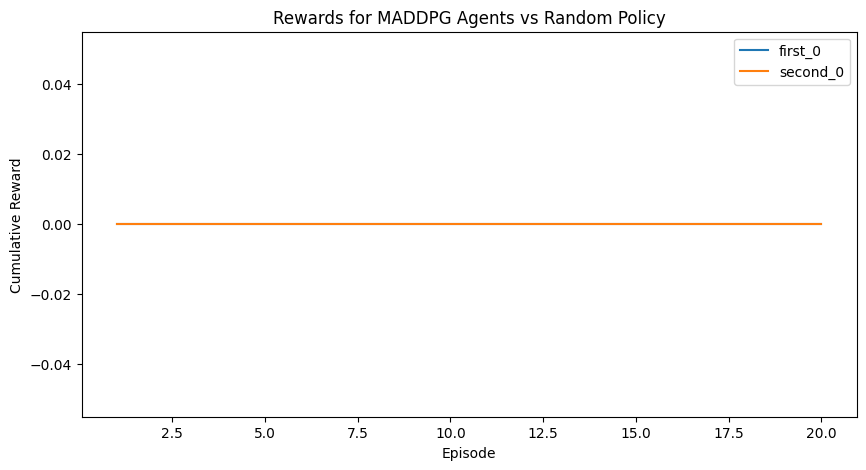

In [11]:
# Directory where checkpoints are saved
checkpoint_dir = "maddpg_checkpoints"

# Load checkpoint for episode 25
load_checkpoint(maddpg, checkpoint_dir, episode_number=25)

# Test the trained agents
test_rewards = test_agent_against_random(maddpg, parallel_env, num_test_episodes=10, max_steps=50)

# Plot the rewards
plt.figure(figsize=(10, 5))
for agent, rewards in test_rewards.items():
    plt.plot(range(1, len(rewards) + 1), rewards, label=agent)

plt.title("Rewards for MADDPG Agents vs Random Policy")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()



Testing MADDPG Agent 0 against a Random Policy Agent...
Episode 1/3 (Steps: 5000, Duration: 25.38 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 2/3 (Steps: 5000, Duration: 25.09 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 3/3 (Steps: 5000, Duration: 25.71 seconds):
  first_0: 0.0
  second_0: 0.0


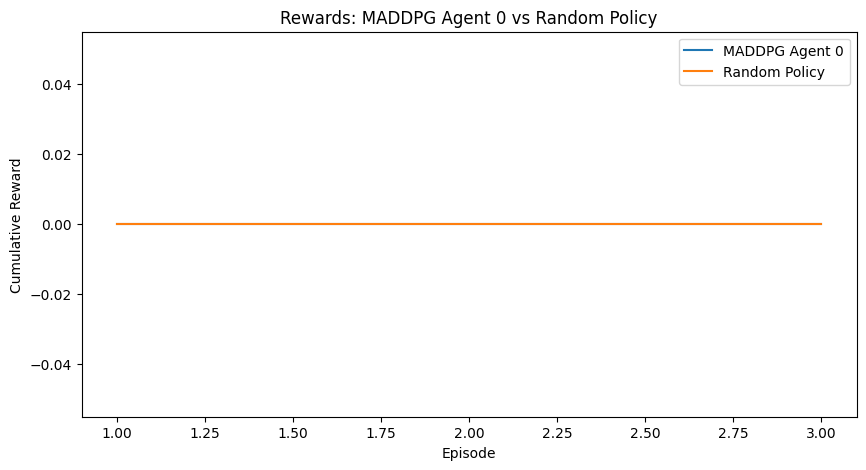


Testing MADDPG Agent 1 against a Random Policy Agent...
Episode 1/3 (Steps: 5000, Duration: 19.29 seconds):
  first_0: 2.0
  second_0: -2.0
Episode 2/3 (Steps: 5000, Duration: 18.63 seconds):
  first_0: 2.0
  second_0: -2.0
Episode 3/3 (Steps: 5000, Duration: 18.61 seconds):
  first_0: -4.0
  second_0: 4.0


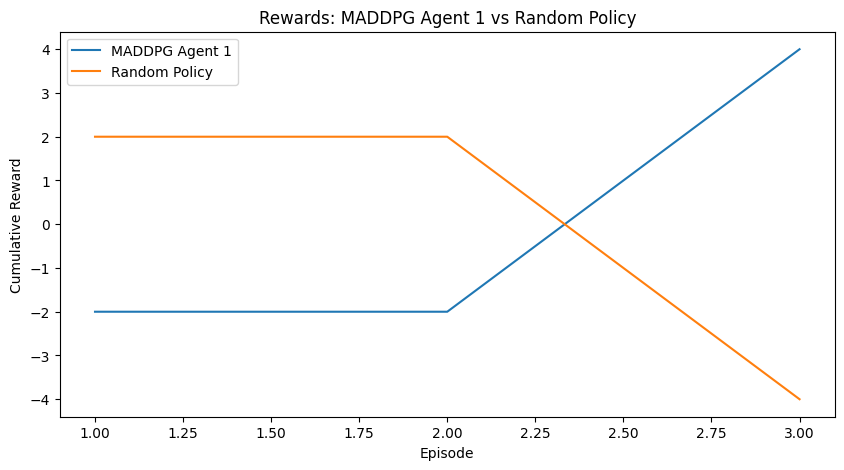

In [16]:
import time

def test_single_maddpg_agent(maddpg, parallel_env, agent_idx, num_test_episodes=10, max_steps=1000):
    """
    Test a single MADDPG agent against a random policy agent.

    Args:
        maddpg: The MADDPG object containing the agents.
        parallel_env: The parallelized PettingZoo environment.
        agent_idx: The index of the MADDPG agent to test (0 or 1).
        num_test_episodes: Number of episodes to run the test.
        max_steps: Maximum number of steps per episode.

    Returns:
        A dictionary of rewards for each agent in the test.
    """
    agent_rewards = defaultdict(list)

    print(f"\nTesting MADDPG Agent {agent_idx} against a Random Policy Agent...")
    for episode in range(num_test_episodes):
        start_time = time.time()  # Start timing the episode

        obs = parallel_env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]  # Handle tuple observations

        done = {agent: False for agent in parallel_env.agents}
        episode_reward = defaultdict(float)  # Track cumulative rewards
        step_count = 0  # Step counter for the episode

        while not all(done.values()) and step_count < max_steps:
            actions = {}
            for agent in parallel_env.agents:
                if int(agent.split('_')[1]) == agent_idx:  # MADDPG agent
                    obs_preprocessed = torch.tensor(obs[agent], dtype=torch.float32)
                    if len(obs_preprocessed.shape) > 2:  # Ensure grayscale
                        obs_preprocessed = obs_preprocessed.mean(axis=-1)
                    obs_preprocessed = obs_preprocessed.flatten().unsqueeze(0)

                    # MADDPG agent's action
                    action = maddpg.agents[agent_idx].actor(obs_preprocessed).detach().numpy()
                    actions[agent] = np.argmax(action)  # Convert to discrete action
                else:  # Random policy agent
                    actions[agent] = parallel_env.action_space(agent).sample()

            # Step the environment
            step_output = parallel_env.step(actions)
            if isinstance(step_output, tuple):
                next_obs, rewards, dones, truncations, infos = step_output
                dones = {agent: dones[agent] or truncations[agent] for agent in dones}
            else:
                next_obs, rewards, dones, infos = step_output

            # Accumulate rewards
            for agent, reward in rewards.items():
                episode_reward[agent] += reward

            obs = next_obs
            step_count += 1  # Increment step count

        # Record cumulative rewards for the episode
        for agent in parallel_env.agents:
            agent_rewards[agent].append(episode_reward[agent])

        # End timing the episode
        end_time = time.time()
        episode_duration = end_time - start_time

        print(f"Episode {episode + 1}/{num_test_episodes} (Steps: {step_count}, Duration: {episode_duration:.2f} seconds):")
        for agent, reward in episode_reward.items():
            print(f"  {agent}: {reward}")

    return agent_rewards


# Test each MADDPG agent against a random policy agent
for test_agent_idx in range(len(maddpg.agents)):  # Test for each MADDPG agent (0 and 1)
    rewards = test_single_maddpg_agent(maddpg, parallel_env, agent_idx=test_agent_idx, num_test_episodes=3, max_steps=5000)

    # Plot the rewards for the tested agent
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(rewards[parallel_env.agents[test_agent_idx]]) + 1),
             rewards[parallel_env.agents[test_agent_idx]], label=f"MADDPG Agent {test_agent_idx}")
    plt.plot(range(1, len(rewards[parallel_env.agents[1 - test_agent_idx]]) + 1),
             rewards[parallel_env.agents[1 - test_agent_idx]], label="Random Policy")
    plt.title(f"Rewards: MADDPG Agent {test_agent_idx} vs Random Policy")
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    plt.show()



Testing MADDPG Agent 0 against a Random Policy Agent...
Episode 1/50 (Steps: 5000, Duration: 25.42 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 2/50 (Steps: 5000, Duration: 25.08 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 3/50 (Steps: 5000, Duration: 26.92 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 4/50 (Steps: 5000, Duration: 25.14 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 5/50 (Steps: 5000, Duration: 27.00 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 6/50 (Steps: 5000, Duration: 25.42 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 7/50 (Steps: 5000, Duration: 25.03 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 8/50 (Steps: 5000, Duration: 24.80 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 9/50 (Steps: 5000, Duration: 24.94 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 10/50 (Steps: 5000, Duration: 24.93 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 11/50 (Steps: 5000, Duration: 25.02 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 12/50 (St

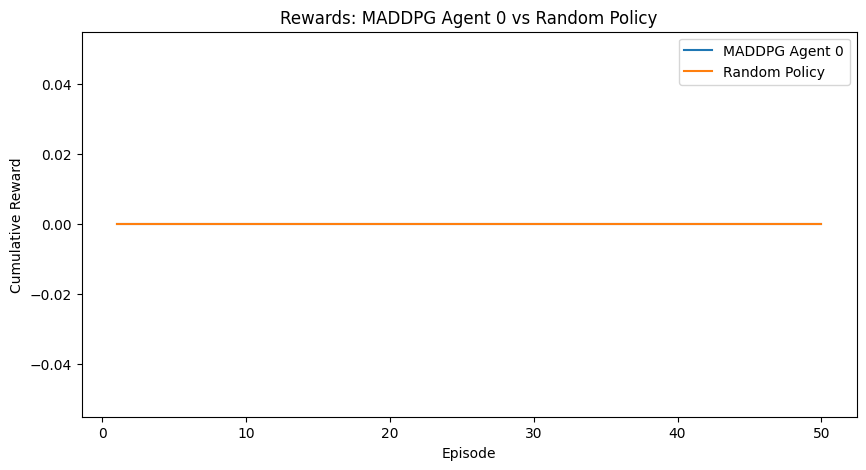


Testing MADDPG Agent 1 against a Random Policy Agent...
Episode 1/50 (Steps: 5000, Duration: 18.90 seconds):
  first_0: -1.0
  second_0: 1.0
Episode 2/50 (Steps: 5000, Duration: 18.69 seconds):
  first_0: 1.0
  second_0: -1.0
Episode 3/50 (Steps: 5000, Duration: 18.84 seconds):
  first_0: -5.0
  second_0: 5.0
Episode 4/50 (Steps: 5000, Duration: 18.76 seconds):
  first_0: -1.0
  second_0: 1.0
Episode 5/50 (Steps: 5000, Duration: 18.64 seconds):
  first_0: -2.0
  second_0: 2.0
Episode 6/50 (Steps: 5000, Duration: 18.81 seconds):
  first_0: -1.0
  second_0: 1.0
Episode 7/50 (Steps: 5000, Duration: 18.58 seconds):
  first_0: 4.0
  second_0: -4.0
Episode 8/50 (Steps: 5000, Duration: 18.63 seconds):
  first_0: 1.0
  second_0: -1.0
Episode 9/50 (Steps: 5000, Duration: 18.83 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 10/50 (Steps: 5000, Duration: 18.62 seconds):
  first_0: -1.0
  second_0: 1.0
Episode 11/50 (Steps: 5000, Duration: 18.70 seconds):
  first_0: 3.0
  second_0: -3.0
Episode

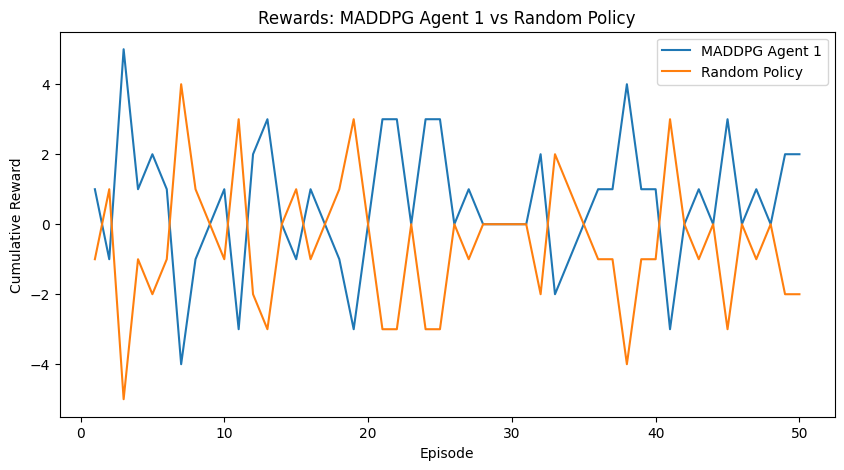

In [17]:
import time

def test_single_maddpg_agent(maddpg, parallel_env, agent_idx, num_test_episodes=50, max_steps=1000):
    """
    Test a single MADDPG agent against a random policy agent.

    Args:
        maddpg: The MADDPG object containing the agents.
        parallel_env: The parallelized PettingZoo environment.
        agent_idx: The index of the MADDPG agent to test (0 or 1).
        num_test_episodes: Number of episodes to run the test.
        max_steps: Maximum number of steps per episode.

    Returns:
        A dictionary of rewards for each agent in the test.
    """
    agent_rewards = defaultdict(list)

    print(f"\nTesting MADDPG Agent {agent_idx} against a Random Policy Agent...")
    for episode in range(num_test_episodes):
        start_time = time.time()  # Start timing the episode

        obs = parallel_env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]  # Handle tuple observations

        done = {agent: False for agent in parallel_env.agents}
        episode_reward = defaultdict(float)  # Track cumulative rewards
        step_count = 0  # Step counter for the episode

        while not all(done.values()) and step_count < max_steps:
            actions = {}
            for agent in parallel_env.agents:
                if int(agent.split('_')[1]) == agent_idx:  # MADDPG agent
                    obs_preprocessed = torch.tensor(obs[agent], dtype=torch.float32)
                    if len(obs_preprocessed.shape) > 2:  # Ensure grayscale
                        obs_preprocessed = obs_preprocessed.mean(axis=-1)
                    obs_preprocessed = obs_preprocessed.flatten().unsqueeze(0)

                    # MADDPG agent's action
                    action = maddpg.agents[agent_idx].actor(obs_preprocessed).detach().numpy()
                    actions[agent] = np.argmax(action)  # Convert to discrete action
                else:  # Random policy agent
                    actions[agent] = parallel_env.action_space(agent).sample()

            # Step the environment
            step_output = parallel_env.step(actions)
            if isinstance(step_output, tuple):
                next_obs, rewards, dones, truncations, infos = step_output
                dones = {agent: dones[agent] or truncations[agent] for agent in dones}
            else:
                next_obs, rewards, dones, infos = step_output

            # Accumulate rewards
            for agent, reward in rewards.items():
                episode_reward[agent] += reward

            obs = next_obs
            step_count += 1  # Increment step count

        # Record cumulative rewards for the episode
        for agent in parallel_env.agents:
            agent_rewards[agent].append(episode_reward[agent])

        # End timing the episode
        end_time = time.time()
        episode_duration = end_time - start_time

        print(f"Episode {episode + 1}/{num_test_episodes} (Steps: {step_count}, Duration: {episode_duration:.2f} seconds):")
        for agent, reward in episode_reward.items():
            print(f"  {agent}: {reward}")

    return agent_rewards


# Test each MADDPG agent against a random policy agent
for test_agent_idx in range(len(maddpg.agents)):  # Test for each MADDPG agent (0 and 1)
    rewards = test_single_maddpg_agent(maddpg, parallel_env, agent_idx=test_agent_idx, num_test_episodes=50, max_steps=5000)

    # Plot the rewards for the tested agent
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(rewards[parallel_env.agents[test_agent_idx]]) + 1),
             rewards[parallel_env.agents[test_agent_idx]], label=f"MADDPG Agent {test_agent_idx}")
    plt.plot(range(1, len(rewards[parallel_env.agents[1 - test_agent_idx]]) + 1),
             rewards[parallel_env.agents[1 - test_agent_idx]], label="Random Policy")
    plt.title(f"Rewards: MADDPG Agent {test_agent_idx} vs Random Policy")
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    plt.show()


## Agent_1 versus random policy

In [19]:
# Add win, draw, loss
def test_single_maddpg_agent(maddpg, parallel_env, agent_idx, num_test_episodes=10, max_steps=1000):
    """
    Test a single MADDPG agent against a random policy agent.

    Args:
        maddpg: The MADDPG object containing the agents.
        parallel_env: The parallelized PettingZoo environment.
        agent_idx: The index of the MADDPG agent to test (0 or 1).
        num_test_episodes: Number of episodes to run the test.
        max_steps: Maximum number of steps per episode.

    Returns:
        A dictionary of rewards for each agent in the test, along with win/draw/loss counts.
    """
    agent_rewards = defaultdict(list)
    wins, draws, losses = 0, 0, 0  # Counters for wins, draws, and losses

    print(f"\nTesting MADDPG Agent {agent_idx} against a Random Policy Agent...")
    for episode in range(num_test_episodes):
        start_time = time.time()  # Start timing the episode

        obs = parallel_env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]  # Handle tuple observations

        done = {agent: False for agent in parallel_env.agents}
        episode_reward = defaultdict(float)  # Track cumulative rewards
        step_count = 0  # Step counter for the episode

        while not all(done.values()) and step_count < max_steps:
            actions = {}
            for agent in parallel_env.agents:
                if int(agent.split('_')[1]) == agent_idx:  # MADDPG agent
                    obs_preprocessed = torch.tensor(obs[agent], dtype=torch.float32)
                    if len(obs_preprocessed.shape) > 2:  # Ensure grayscale
                        obs_preprocessed = obs_preprocessed.mean(axis=-1)
                    obs_preprocessed = obs_preprocessed.flatten().unsqueeze(0)

                    # MADDPG agent's action
                    action = maddpg.agents[agent_idx].actor(obs_preprocessed).detach().numpy()
                    actions[agent] = np.argmax(action)  # Convert to discrete action
                else:  # Random policy agent
                    actions[agent] = parallel_env.action_space(agent).sample()

            # Step the environment
            step_output = parallel_env.step(actions)
            if isinstance(step_output, tuple):
                next_obs, rewards, dones, truncations, infos = step_output
                dones = {agent: dones[agent] or truncations[agent] for agent in dones}
            else:
                next_obs, rewards, dones, infos = step_output

            # Accumulate rewards
            for agent, reward in rewards.items():
                episode_reward[agent] += reward

            obs = next_obs
            step_count += 1  # Increment step count

        # Record cumulative rewards for the episode
        for agent in parallel_env.agents:
            agent_rewards[agent].append(episode_reward[agent])

        # Calculate win/draw/loss
        maddpg_agent_reward = episode_reward[parallel_env.agents[agent_idx]]
        random_policy_reward = episode_reward[parallel_env.agents[1 - agent_idx]]

        if maddpg_agent_reward > random_policy_reward:
            wins += 1
        elif maddpg_agent_reward < random_policy_reward:
            losses += 1
        else:
            draws += 1

        # End timing the episode
        end_time = time.time()
        episode_duration = end_time - start_time

        print(f"Episode {episode + 1}/{num_test_episodes} (Steps: {step_count}, Duration: {episode_duration:.2f} seconds):")
        for agent, reward in episode_reward.items():
            print(f"  {agent}: {reward}")

    # Print summary of results
    print("\n--- Test Summary ---")
    print(f"Total Episodes: {num_test_episodes}")
    print(f"  Wins:   {wins}")
    print(f"  Losses: {losses}")
    print(f"  Draws:  {draws}")

    return agent_rewards



Testing MADDPG Agent 1 against a Random Policy Agent...
Episode 1/100 (Steps: 5000, Duration: 20.56 seconds):
  first_0: -1.0
  second_0: 1.0
Episode 2/100 (Steps: 5000, Duration: 20.42 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 3/100 (Steps: 5000, Duration: 19.42 seconds):
  first_0: 1.0
  second_0: -1.0
Episode 4/100 (Steps: 5000, Duration: 19.28 seconds):
  first_0: 2.0
  second_0: -2.0
Episode 5/100 (Steps: 5000, Duration: 19.10 seconds):
  first_0: 0.0
  second_0: 0.0
Episode 6/100 (Steps: 5000, Duration: 17.80 seconds):
  first_0: 1.0
  second_0: -1.0
Episode 7/100 (Steps: 5000, Duration: 19.44 seconds):
  first_0: -1.0
  second_0: 1.0
Episode 8/100 (Steps: 5000, Duration: 19.02 seconds):
  first_0: -8.0
  second_0: 8.0
Episode 9/100 (Steps: 5000, Duration: 19.64 seconds):
  first_0: 9.0
  second_0: -9.0
Episode 10/100 (Steps: 5000, Duration: 19.33 seconds):
  first_0: -2.0
  second_0: 2.0
Episode 11/100 (Steps: 5000, Duration: 19.01 seconds):
  first_0: -2.0
  second_0: 2

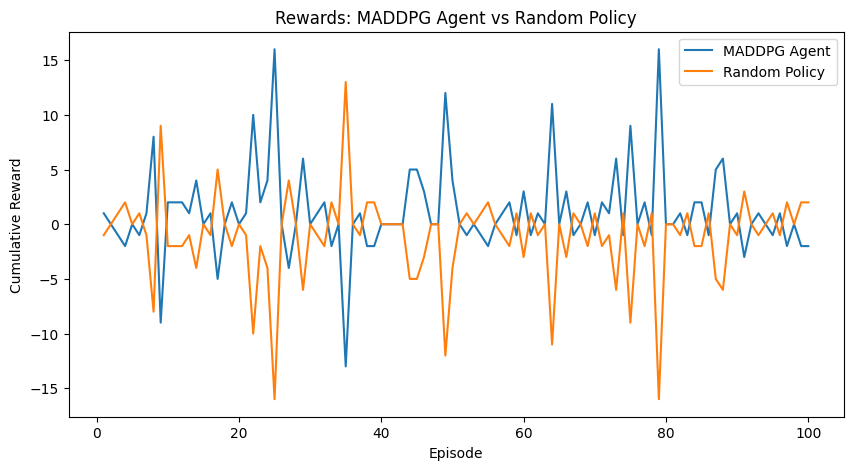

In [20]:
# Test MADDPG agent_1 against a random policy agent
agent_idx_to_test = 1  # Specify the MADDPG agent index (1 in this case)
rewards = test_single_maddpg_agent(maddpg, parallel_env, agent_idx=agent_idx_to_test, num_test_episodes=100, max_steps=5000)

# Plot the rewards for the tested agent
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rewards[parallel_env.agents[agent_idx_to_test]]) + 1),
         rewards[parallel_env.agents[agent_idx_to_test]], label="MADDPG Agent")
plt.plot(range(1, len(rewards[parallel_env.agents[1 - agent_idx_to_test]]) + 1),
         rewards[parallel_env.agents[1 - agent_idx_to_test]], label="Random Policy")
plt.title(f"Rewards: MADDPG Agent vs Random Policy")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()


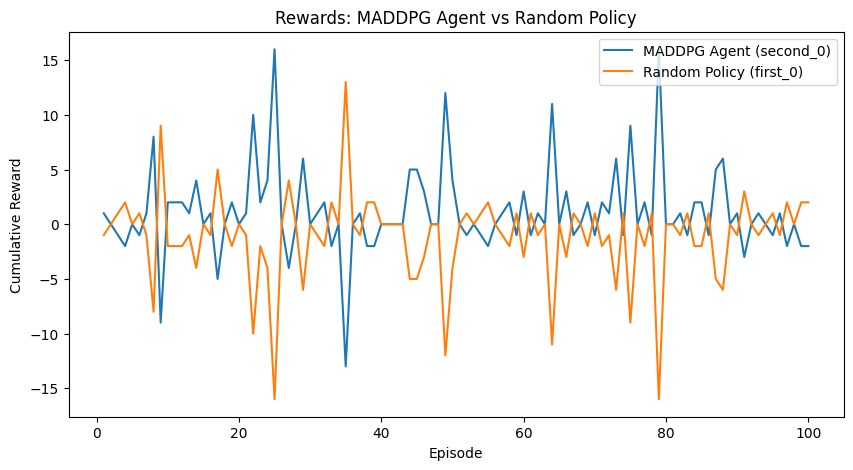

In [36]:
# Correct Label
# Plot the rewards for the tested agent with correct labels
tested_agent_label = f"MADDPG Agent (second_0)"
random_policy_label = f"Random Policy (first_0)"

# Plot the rewards for the tested agent
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(rewards["second_0"]) + 1),
         rewards["second_0"], label=tested_agent_label)
plt.plot(range(1, len(rewards["first_0"]) + 1),
         rewards["first_0"], label=random_policy_label)
plt.title(f"Rewards: MADDPG Agent vs Random Policy")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.show()

In [38]:
# Calculate and print average rewards for each agent
def calculate_average_rewards(reward_dict):
    for agent, rewards in reward_dict.items():
        if rewards:  # Check if there are rewards in the list
            avg_reward = sum(rewards) / len(rewards)
            print(f"Average reward for {agent}: {avg_reward:.2f}")
        else:
            print(f"No rewards recorded for {agent}.")

# Example usage with your reward dictionary
calculate_average_rewards(rewards)


Average reward for first_0: -1.11
Average reward for second_0: 1.11


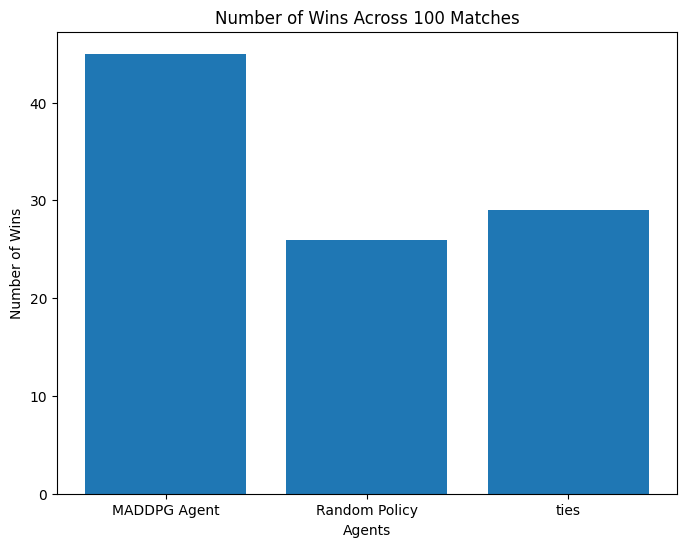

In [25]:
import matplotlib.pyplot as plt

# Example data
categories = ['MADDPG Agent', 'Random Policy', 'ties']
win_counts = [45, 26, 29]  # Replace with actual win counts from your data

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(categories, win_counts)
plt.title('Number of Wins Across 100 Matches')
plt.xlabel('Agents')
plt.ylabel('Number of Wins')
plt.show()
